#### Step 1 : Importing Libraries

In [1]:
%matplotlib inline
from __future__ import print_function
from statsmodels.compat import lzip
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime, timedelta
import datetime
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn import preprocessing
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

#### Step 2 : Loading and EDA on the dataset

In [2]:
restaurants = pd.read_csv('restaurants.csv')
orders = pd.read_csv('orders.csv')

In [3]:
#merge both the data before EDA
df = pd.merge(orders,restaurants,on=["restaurant_id"],how='left')
df

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food
0,2015-06-01 12:28:28.952789+01:00,2015-06-01 14:12:09.474896+01:00,59.90000,1326,2,6220,UK,London,burritos
1,2015-06-06 17:06:24.434807+01:00,2015-06-06 17:16:27.520253+01:00,24.00000,1326,8,603,UK,London,burritos
2,2015-06-08 14:56:15.503204+01:00,2015-06-08 15:03:39.397496+01:00,15.25000,1326,3,443,UK,London,burritos
3,2015-06-12 15:12:20.497925+01:00,2015-06-12 15:23:30.064683+01:00,28.05000,1326,8,669,UK,London,burritos
4,2015-06-01 13:07:10.794050+01:00,2015-06-01 14:02:25.104517+01:00,56.30000,255,7,3314,UK,London,chinese
...,...,...,...,...,...,...,...,...,...
32389,2015-06-30 21:00:29.131078+01:00,2015-06-30 21:15:42.809359+01:00,35.15000,3185,4,913,UK,Glasgow,italian
32390,2015-06-30 22:30:51.123180+02:00,2015-06-30 22:34:12.850308+02:00,9.15771,3556,3,201,Germany,Berlin,vietnamese
32391,2015-06-30 21:50:11.585362+01:00,2015-06-30 22:04:35.205075+01:00,18.20000,3517,3,863,UK,Cheltenham,indian
32392,2015-06-30 22:17:55.778938+01:00,2015-06-30 22:40:15.487549+01:00,21.50000,1705,3,1339,UK,London,italian


In [4]:
# Checking the shape of the dataframe 
df.shape

(32394, 9)

=> So as we can clearly see that there are 9 columns so we need to take some decisions before proceeding ahead with doing EDA then model building, we will first check if there are missing values in the dataframe, If there are missing values we need to handle those mising values

#### Checking Missing Values and Reducing Number of Columns

In [5]:
# We will check the name of the columns having missing values in the dataframe 
df.columns[df.isnull().any()]

Index([], dtype='object')

=> So we can clearly see that there are no missing values in the dataframe , now we will check the number of unique values in each column

#### Checking the number of unique values in each column of dataframe

In [6]:
df.nunique()

order_acknowledged_at    32394
order_ready_at           32394
order_value_gbp           2845
restaurant_id             1697
number_of_items             29
prep_time_seconds         4104
country                      4
city                        22
type_of_food                83
dtype: int64

=> No columns having only one unique values in the dataframe

#### Removing outliers

In [7]:
r = df.describe()

#removing lower and upper outliers of prep_time_seconds
df = df[(df.prep_time_seconds < np.percentile(df.prep_time_seconds,99)) & (df.prep_time_seconds > np.percentile(df.prep_time_seconds,1))]
r

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
count,32394.000000,32394.000000,32394.000000,32394.000000
mean,26.547303,1290.555535,4.025715,1299.993857
std,19.263851,960.295504,2.392063,4404.573191
min,0.500000,3.000000,1.000000,0.000000
25%,16.700000,408.000000,3.000000,518.000000
50%,21.400000,1160.000000,3.000000,820.000000
75%,30.250000,2117.000000,5.000000,1227.000000
max,711.000000,3622.000000,38.000000,255499.000000


=> notice prep_time_seconds = 0 and prep_time_seconds > 2days
->removing...

In [8]:
dc = df.groupby(["country"])["country"].count()
#df.groupby(["country","city","restaurant_id"])["city"].count().sort_values()
df = df[df["country"]=="UK"]
dc

country
France      1912
Germany      320
Ireland      343
UK         29140
Name: country, dtype: int64

=> contains order level data from 4 european countries 
mostly from uk (90%) ->removing rest...

In [9]:
#df.groupby(["country"]).agg(z=('prep_time_seconds', np.mean))
df.groupby(["city"]).agg(avg_prep_time=('prep_time_seconds', np.mean))
dw = df.groupby(["city"])["city"].count().sort_values()
df = df[(df["city"]!="Cardiff") & (df["city"]!="Leicester") & (df["city"]!="Southampton")]
dw

city
Southampton        2
Cardiff            5
Leicester          9
Cheltenham        11
Bristol           86
Guildford        108
Reading          126
Liverpool        152
Glasgow          170
Cambridge        176
Leeds            221
Nottingham       224
Birmingham       272
Edinburgh        427
Oxford           534
Brighton         643
Manchester       939
London         25035
Name: city, dtype: int64

=>3 cities have less that 10 order ->removing...

### Performing EDA

#### Food type

In [10]:
sorted(df.type_of_food.unique())
#<100 types of food, hence doing manual data cleaning
df = df.replace("delicatessen","deli")
df.type_of_food.unique()

array(['burritos', 'chinese', 'healthy', 'dessert', 'thai', 'american',
       'persian', 'sandwiches', 'mediterranean', 'british', 'italian',
       'french', 'lebanese', 'japanese', 'burgers', 'mexican', 'chicken',
       'deli', 'turkish', 'vietnamese', 'argentinian', 'modern british',
       'bakery', 'korean', 'pan asian', 'european', 'indonesian',
       'indian', 'ramen', 'australian', 'bbq', 'spanish', 'sweet treats',
       'greek', 'peruvian', 'north african', 'juices', 'vegan',
       'middle eastern', 'rotisserie', 'brazilian', 'caribbean', 'pizza',
       'seafood', 'international', 'ethiopian', 'fish and chips',
       'latin american', 'south indian', 'sichuan chinese',
       'lebanese moroccan', 'georgian', 'bistro', 'taiwanese',
       'malaysian', 'french lebanese', 'south african', 'portuguese',
       'diner', 'scandinavian', 'austrian', 'german', 'bagels', 'sushi',
       'nepalese', 'spanish tapas', 'scottish', 'soup', 'asian fusion',
       'creole', 'creperie',

=> we see delicatessen and deli as seperate, we shall combine it to deli

In [11]:
dff = df[df["type_of_food"]=='burgers']
dff.groupby(["country","city","type_of_food"]).agg(z=('prep_time_seconds', np.mean))

z
country city       type_of_food             
UK      Birmingham burgers       1400.542857
        Brighton   burgers       1155.089744
        Bristol    burgers       1559.615385
        Cambridge  burgers        978.423077
        Edinburgh  burgers       1425.490566
        Glasgow    burgers       1281.645161
        Guildford  burgers       1263.900000
        Leeds      burgers        759.500000
        Liverpool  burgers       1462.333333
        London     burgers        971.177814
        Manchester burgers        933.480916
        Nottingham burgers        974.451613
        Oxford     burgers        863.300000
        Reading    burgers       1431.125000

=>same type of food can have very different prep time in different cities, cant remove cities as a feature

In [12]:
dft = df.groupby(["type_of_food"]).agg(foodtype_apt=('prep_time_seconds', np.mean))
dft['foodtype_apt']  = dft['foodtype_apt'].astype(int)  
df = pd.merge(df,dft,on=["type_of_food"],how='left')

=> replacing discrete categorical variable type of food with its numerical proxy average prep time of the type of food 

#### Order time

In [13]:
print(df.order_acknowledged_at.min()," to ",df.order_acknowledged_at.max())
#just one month of data, so no seasonality or long term trend
#cant use time series analysis

#extracting weekday and hour of order_acknowledged_at to retain peak hour / peak day importance
df['order_acknowledged_at'] = pd.to_datetime(df['order_acknowledged_at'], utc=True)
df['order_ready_at'] = pd.to_datetime(df['order_ready_at'], utc=True)

df['weekday'] = pd.to_datetime(df['order_acknowledged_at'], utc=True).dt.weekday

df['hour'] = pd.to_datetime(df['order_acknowledged_at'], utc=True).dt.hour
df['date'] = pd.to_datetime(df['order_acknowledged_at'], utc=True).dt.date
df['dt2'] = pd.to_datetime(df['order_acknowledged_at'], utc=True).dt.floor('h')

2015-06-01 11:22:56.328104+01:00  to  2015-07-01 00:03:12.344312+01:00


=> Just one month of data, so no seasonality or long term trend, cant use time series analysis

<AxesSubplot:xlabel='hour'>

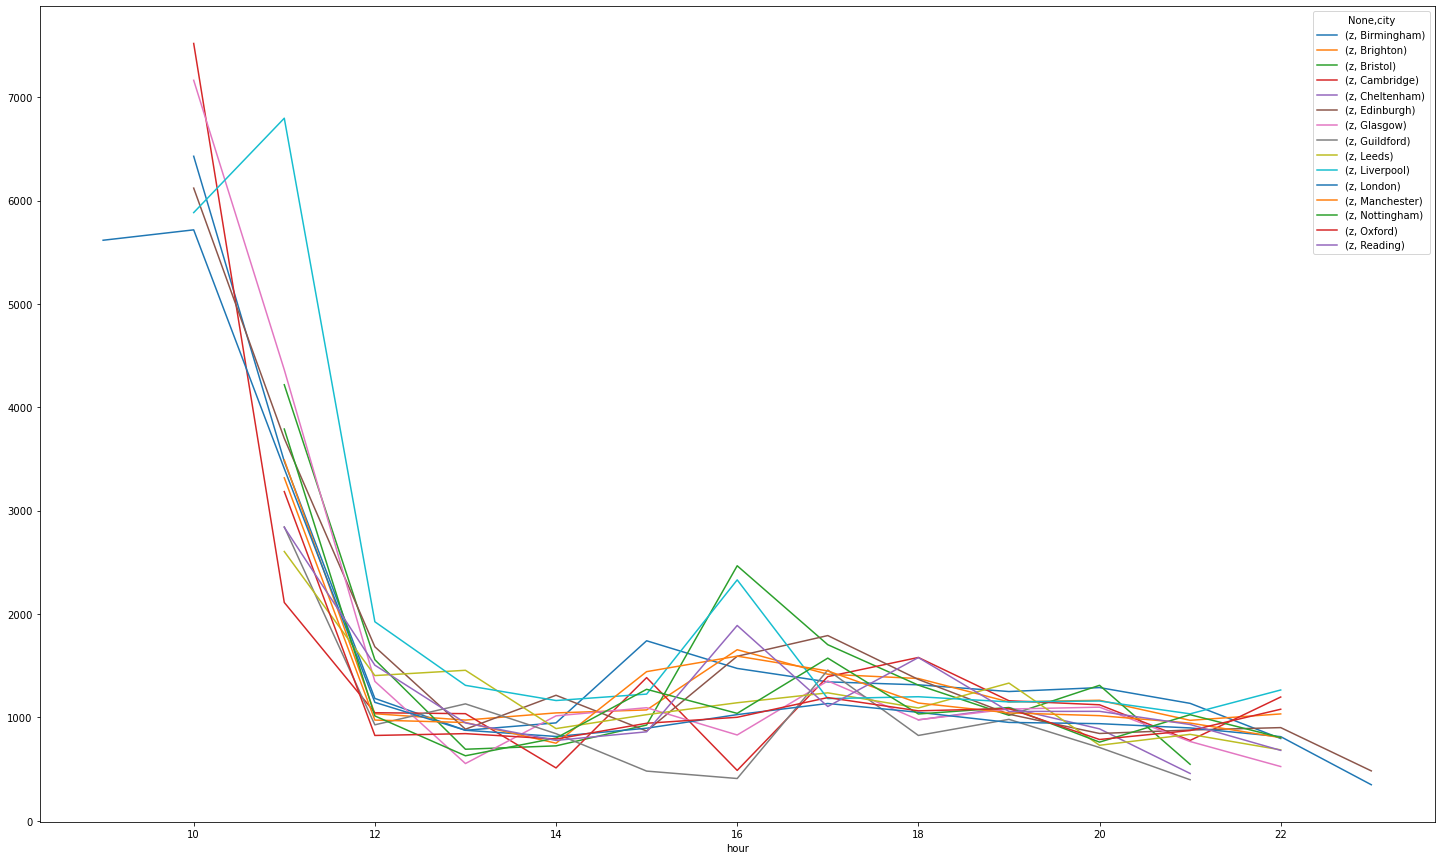

In [14]:
#checking if hour is an important factor to determine prep time

df1 = df.groupby(["country","city","hour"]).agg(z=('prep_time_seconds', np.mean))
df1 = df1.reset_index()
df1 = df1[df1["country"]=='UK']

df11 = df1.pivot("hour", columns="city" )
df11.plot(figsize=(25,15))

=> hour looks like an important feature explaining preperation time, logically also acceptable, we see anomaly in 16hr for example, assumption is this is peak hours for only some cities because people return back from home/work. we shall introduce some other metric that record the active orders in that hour to further deep dive. or could'be effect of tourist location on weekend or particular weekday

In [15]:
dff = df.groupby(by=["city","type_of_food"])["country"].count().sort_values(ascending = False).reset_index()
dff.groupby(by=["city","type_of_food"])["country"].nlargest(5)

0      3733
1      3110
2      2367
3      1584
4      1473
       ... 
270       1
271       1
272       1
273       1
274       1
Name: country, Length: 275, dtype: int64

#### Active orders & Active items

looping over the data to record active orders at the same time.  
we assume if the ack time of an order falls between ack time & ready time of another =>  they're active to one another


In [16]:

d1 = pd.DataFrame(columns = df.columns)

rest = list(df['restaurant_id'].unique())
for h in rest:
    dfh = df[df["restaurant_id"]==h].reset_index()
    dfh['active_orders']=0
    dfh['active_items']=0
    for i in range(len(dfh)):
        k=0
        l=0
        for j in range(len(dfh)):
            if(dfh['order_acknowledged_at'][i] < dfh['order_ready_at'][j]):
                if(dfh['order_acknowledged_at'][i] > dfh['order_acknowledged_at'][j]):
                    k+=1
                    l+=dfh["number_of_items"][j]
        dfh['active_orders'][i]=k
        dfh['active_items'][i]=l

    d1 = d1.append(dfh,ignore_index = True)
    
d2 = d1.reset_index()
del(d2[d2.columns[0]])
d2 = d2.drop("index", axis = 1)

df = d2

<AxesSubplot:xlabel='active_items', ylabel='prep_time_seconds'>

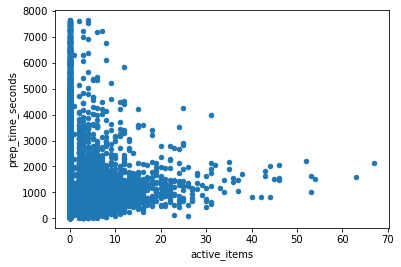

In [17]:
d3 = d2
#d3 = d3[d3["restaurant_id"]==365]
#d3 = d3[d3["hour"]==14]
#d3 = d3[d3["weekday"]==5]
d3 = d3[["active_items","prep_time_seconds"]]
d3.plot("active_items","prep_time_seconds",kind = "scatter")

<AxesSubplot:>

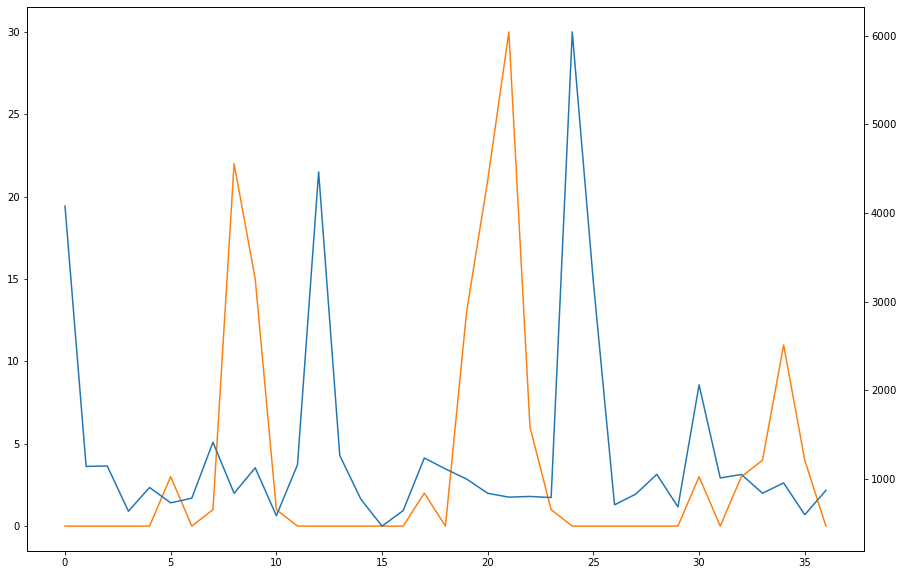

In [18]:
#df.groupby(["city"]).agg(sum)

df2 = df[df["city"]=="London"]
df2 = df2[df2["dt2"]<"2015-06-04"]
df2 = df2[df2["type_of_food"]=="italian"]
df2 = df2.groupby(["dt2"]).agg(pt=('prep_time_seconds', np.mean),cc=('active_items',np.sum))


df2 = df2.reset_index()

#df2 = df2.drop(["dt2"], axis=1)
#df22 = df2.pivot("dt2", columns="type_of_food")

df2.pt.plot(x="dt2",secondary_y = True ,figsize=(35,15))
df2.cc.plot(x="dt2" ,figsize=(15,10))

In [19]:
#calculating active order at hour level
df5 = df[["restaurant_id","dt2","number_of_items"]]
df5 = df5.groupby(["restaurant_id","dt2"]).agg(active_items_hr=('number_of_items', np.size),active_orders_hr=('number_of_items', np.size))
df = pd.merge(df,df5,on=["restaurant_id","dt2"],how='left')

#### Weekday

<AxesSubplot:xlabel='hour'>

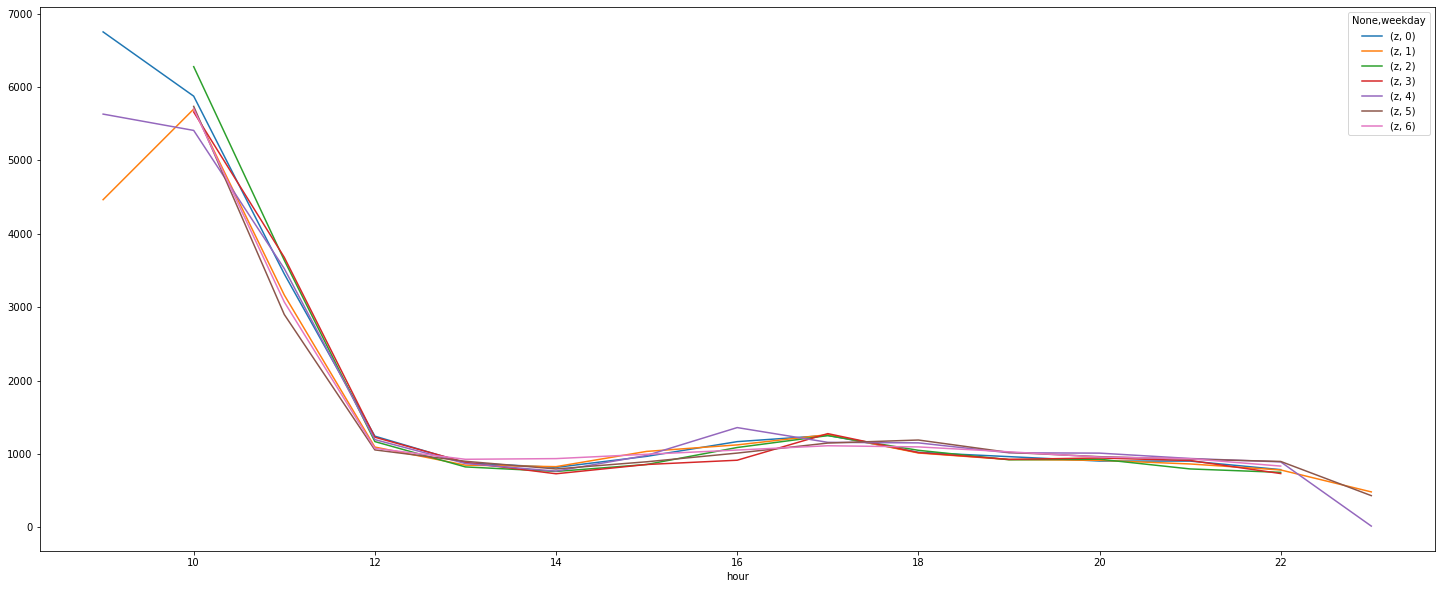

In [20]:
df1 = df.groupby(["hour","weekday"]).agg(z=('prep_time_seconds', np.mean))
df1 = df1.reset_index()

df11 = df1.pivot("hour", columns="weekday" )
df11.plot(figsize=(25,10))

,z
weekday,4
city,
Birmingham,1446.083333
Brighton,1390.284314
Bristol,1006.375000
Cambridge,1782.678571
Edinburgh,1367.405405
Glasgow,1102.028571
Guildford,813.857143
Leeds,1506.568627


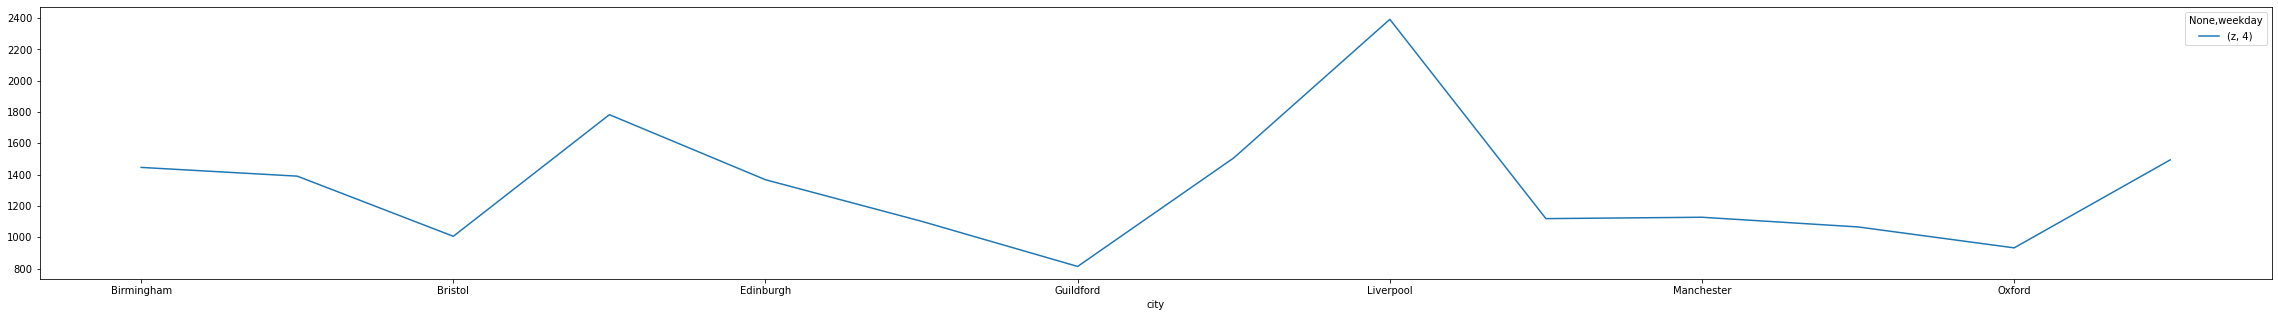

In [21]:
df1 = df[df["weekday"]==4]
df1 = df1.groupby(["city","weekday"]).agg(z=('prep_time_seconds', np.mean))
df1 = df1.reset_index()

df11 = df1.pivot("city", columns="weekday" )
df11.plot(figsize=(40,5))
df11

In [22]:
df = df.drop(["country","date","dt2","type_of_food"], axis=1)
df = df.drop(["order_ready_at","order_acknowledged_at","restaurant_id"], axis=1)

#### One hot encoding - City

In [23]:
#one hot encoding city
df = pd.get_dummies(df, columns = ["city"])
df

,order_value_gbp,number_of_items,prep_time_seconds,foodtype_apt,weekday,hour,active_orders,active_items,active_items_hr,active_orders_hr,...,city_Edinburgh,city_Glasgow,city_Guildford,city_Leeds,city_Liverpool,city_London,city_Manchester,city_Nottingham,city_Oxford,city_Reading
0,59.90,2,6220,772,0,11,0.0,0.0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,24.00,8,603,772,5,16,0.0,0.0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,15.25,3,443,772,0,13,0.0,0.0,1,1,...,0,0,0,0,0,1,0,0,0,0
3,28.05,8,669,772,4,14,0.0,0.0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,56.30,7,3314,1127,0,12,0.0,0.0,1,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29119,16.50,3,377,1082,1,21,1.0,2.0,2,2,...,0,0,0,0,0,1,0,0,0,0
29120,35.15,4,913,1003,1,20,0.0,0.0,1,1,...,0,1,0,0,0,0,0,0,0,0
29121,18.20,3,863,1279,1,20,0.0,0.0,1,1,...,0,0,0,0,0,0,0,0,0,0
29122,21.50,3,1339,1003,1,21,0.0,0.0,1,1,...,0,0,0,0,0,1,0,0,0,0


#### Normalizing data

In [24]:
Y = df["prep_time_seconds"]
X = df.drop("prep_time_seconds",axis=1)

In [25]:
scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#### Histogram plots

In [26]:
# Plot box plot for all columns in the list input_cols.
# Taken Help from Stackoverflow
def box_plot(data,input_cols,ncol):
    leng = len(input_cols)
    if leng%ncol == 0:
        rows = leng//ncol
    else:
        rows = leng//ncol + 1
    
    figure, axes = plt.subplots(nrows=rows, ncols=ncol,figsize=(20,3.5*rows))
    
    for i, xvar in enumerate(input_cols):
            axes[i//ncol,i%ncol].title.set_text(xvar)
            axes[i//ncol,i%ncol].tick_params(axis='x', rotation=45)
            
            axes[i//ncol,i%ncol].boxplot(data[xvar])
            
            
    
    figure.tight_layout(pad=3.0)
    plt.show()
    

    # Plot histogram for all columns in the list input_cols.
def plot_histogram(data, input_cols,ncol):
    leng = len(input_cols)
    if leng%ncol == 0:
        rows = leng//ncol
    else:
        rows = leng//ncol + 1
    fig = plt.figure(figsize=(20,3.5*rows))
    
    for i, xvar in enumerate(input_cols):
        
            fig.add_subplot(rows,ncol,i+1).tick_params(axis='x', rotation=45)
            fig.add_subplot(rows,ncol,i+1).title.set_text(xvar + " histogram")
            sns.distplot(data[xvar],hist = True)
            
    fig.tight_layout(pad=3.0)
    
    
# Plot barplot for all columns in the list input_cols.
def plot_bar(data, input_cols,ncol):
    leng = len(input_cols)
    if leng%ncol == 0:
        rows = leng//ncol
    else:
        rows = leng//ncol + 1
    fig = plt.figure(figsize=(20,3.5*rows))
    
    for i, xvar in enumerate(input_cols):
        
            fig.add_subplot(rows,ncol,i+1).tick_params(axis='x', rotation=45)
            fig.add_subplot(rows,ncol,i+1).title.set_text(xvar + " histogram")
            sns.distplot(data[xvar],hist = True)
            
    fig.tight_layout(pad=3.0)

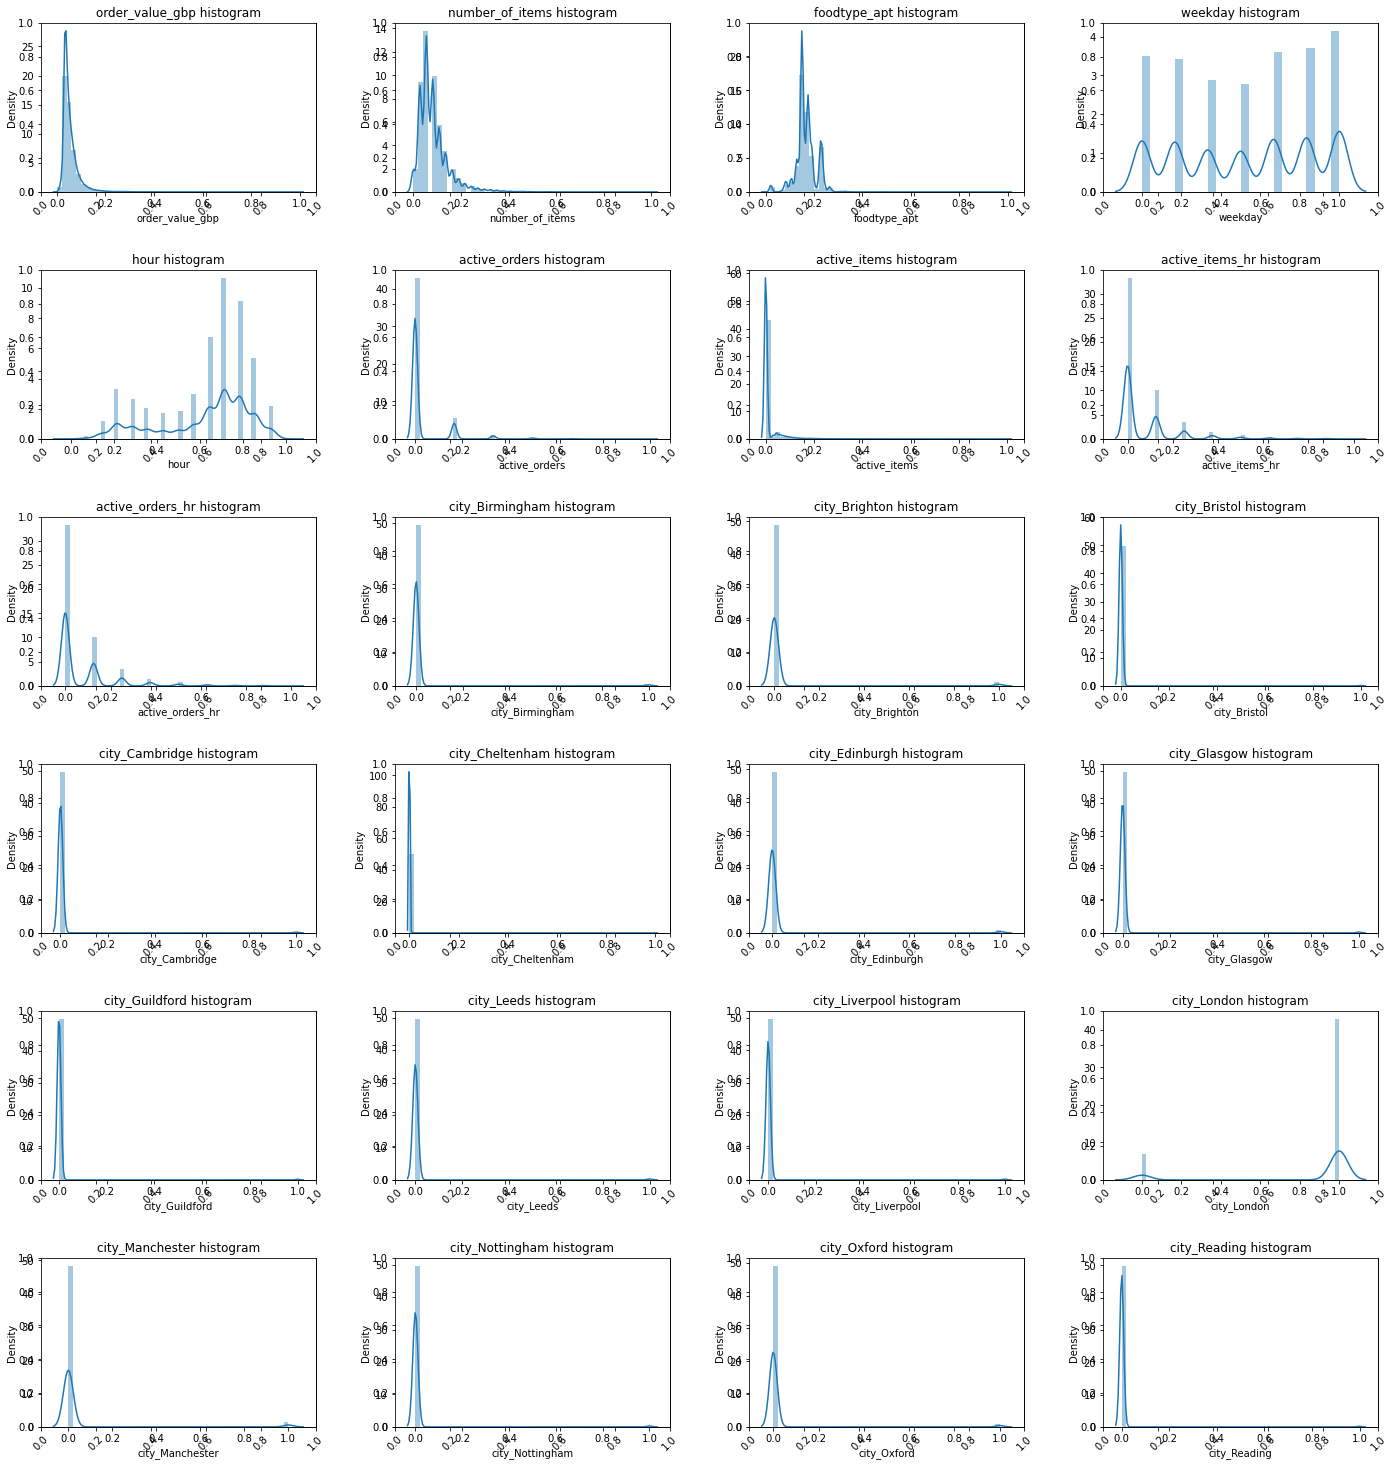

In [27]:
plot_histogram(X,X.columns,4)

#### Correlation

In [28]:
# function to plot correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "Preparation Time"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=39)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=39)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=39)
    plt.show()

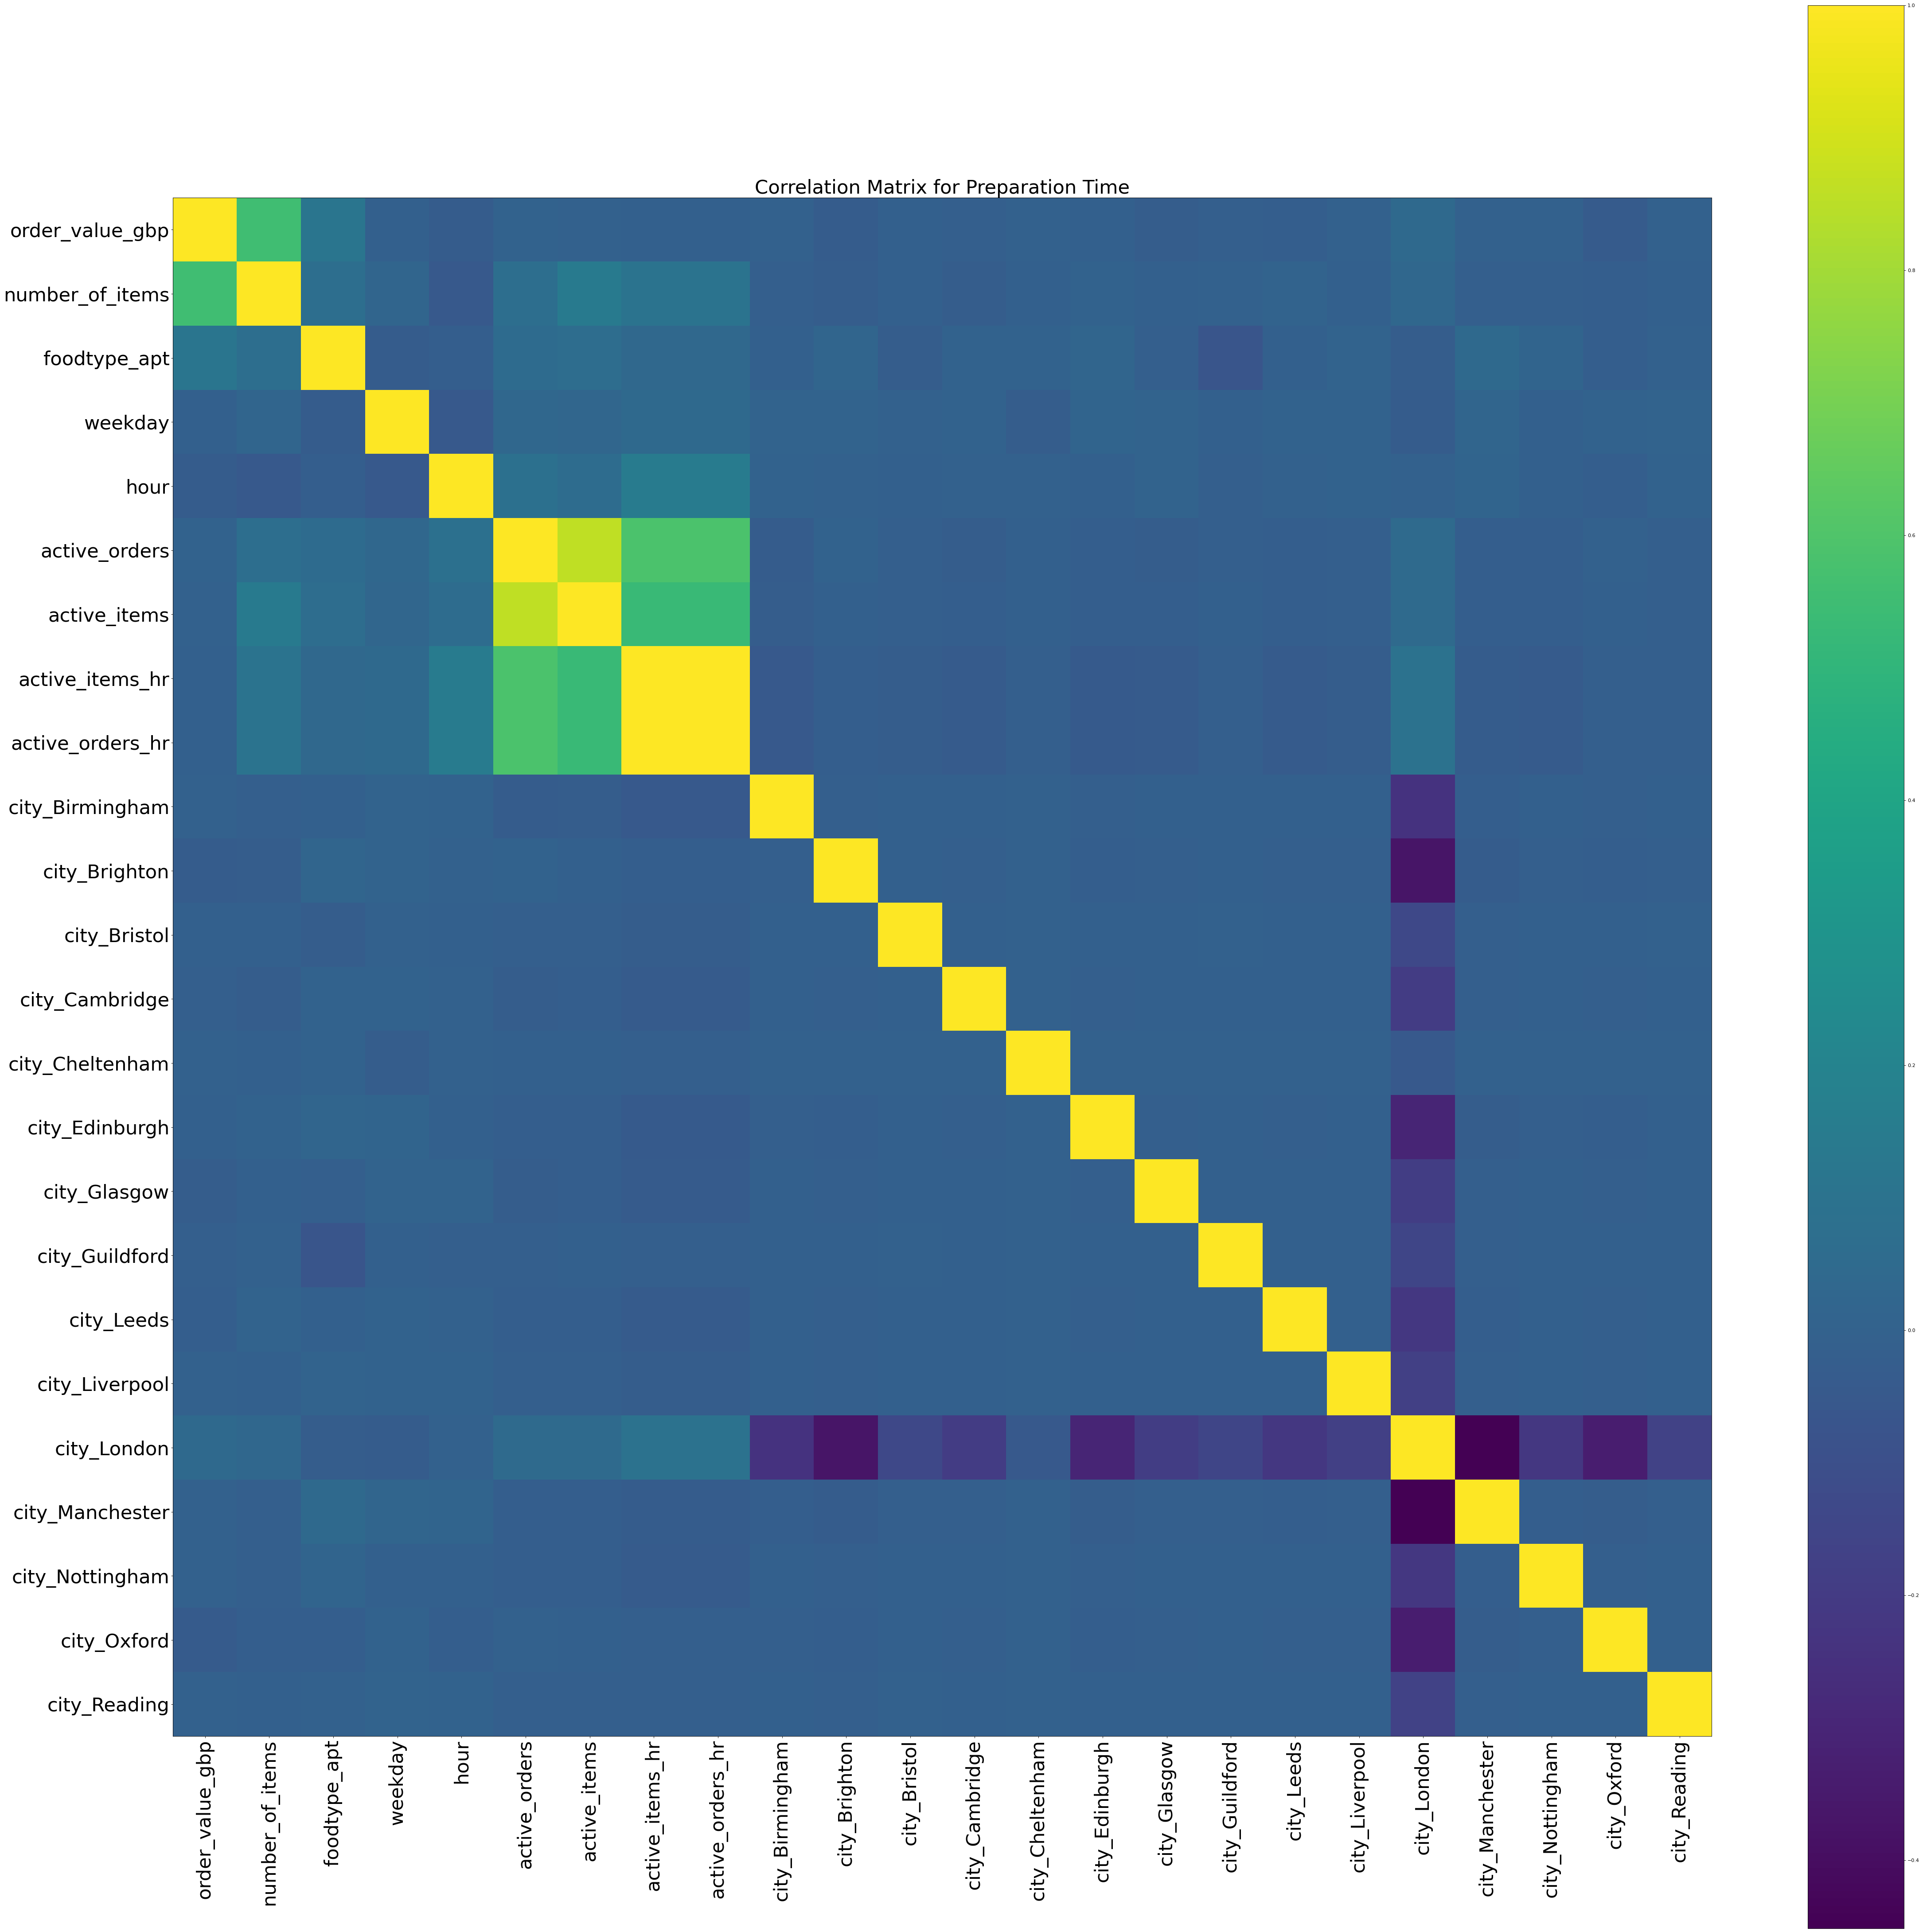

In [29]:
plotCorrelationMatrix(X,70)

#### Test - Train split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [31]:
# print shapes of train and test sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23299, 24)
(23299,)
(5825, 24)
(5825,)


#### Random Forest

In [32]:
# Instantiate model with 1000 decision trees
model2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
model2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [33]:
from sklearn import metrics
y_pred = model2.predict(X_test)
print('R^2:', metrics.r2_score(y_test, y_pred))

R^2: 0.2627493549095762


#### Feature importance

In [34]:
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(model2.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: hour                 Importance: 0.33
Variable: order_value_gbp      Importance: 0.27
Variable: foodtype_apt         Importance: 0.11
Variable: number_of_items      Importance: 0.08
Variable: weekday              Importance: 0.08
Variable: active_items         Importance: 0.02
Variable: active_items_hr      Importance: 0.02
Variable: active_orders_hr     Importance: 0.02
Variable: active_orders        Importance: 0.01
Variable: city_Brighton        Importance: 0.01
Variable: city_London          Importance: 0.01
Variable: city_Manchester      Importance: 0.01
Variable: city_Birmingham      Importance: 0.0
Variable: city_Bristol         Importance: 0.0
Variable: city_Cambridge       Importance: 0.0
Variable: city_Cheltenham      Importance: 0.0
Variable: city_Edinburgh       Importance: 0.0
Variable: city_Glasgow         Importance: 0.0
Variable: city_Guildford       Importance: 0.0
Variable: city_Leeds           Importance: 0.0
Variable: city_Liverpool       Importance: 0.0
V

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [35]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train_le = le.fit_transform(y_train)

In [36]:
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

In [37]:
# # fit model no training data
# model1 = XGBClassifier()
# model1.fit(X_train, y_train_le)

In [38]:
# y_pred_le = model1.predict(X_test)
# y_pred = le.inverse_transform(y_pred_le)

In [39]:
# print('R^2:', metrics.r2_score(y_test, y_pred))